In [1]:
import numpy as np
import scipy
import scipy.sparse as sps
import porepy as pp

import ddf.common as co
import ddf.hrl as hrl
from ddf.plot import quiver, plot_cells, streamplot
from ddf.immagini import *

import os
import pickle
import subprocess

In [2]:
def condensatore(comb):
    eps,l,kb = comb
    
    _,dati = hrl.vg14('D', 1, grid_scale=0.1)

    def verticale(x, y1, y2): return [[x,x],[y1,y2]]
    def orizzontale(y, x1, x2): return [[x1,x2],[y,y]]
    f = [ 
        verticale(5, 2.5, 7.5), verticale(15, 2.5, 7.5),
        orizzontale(2.5, 5, 15), orizzontale(7.5, 5, 10-eps/2), orizzontale(7.5, 10+eps/2, 15) 
    ]
    if eps > 0 and l > 0: f += [ verticale(10-eps/2, 7.5-l/2, 7.5+l/2), verticale(10+eps/2, 7.5-l/2, 7.5+l/2) ]
#     mdg = co.mesh_triangolare(max(100, (20/eps)/5, (20/l)/5), (20, 10), fratture_q=np.array(f))
    mdg = pp.meshing.cart_grid( np.array(f), nx=np.array([200, 100]), physdims=(20, 10) )

    dati['permeabilita_matrice'] = kb

    return mdg, dati

In [3]:
if os.path.isfile('../simulazioni/condensatori.pkl'):
    with open('../simulazioni/condensatori.pkl', 'rb') as f: condensatori = pickle.load(f)
else: condensatori = dict()

combinazioni = [(eps, l, 1e-16*kb_mult) 
    for eps in [0.2, 0.4, 0.8, 1.6, 3.2]
    for l in [0.2, 0.4, 0.8, 1.6, 3.2]
    for kb_mult in [0.1, 0.3, 1.0, 3.0]
]
combinazioni += [(eps, l, 1e-16)
    for eps in [0.2, 0.4, 0.6, 0.8, 1.2, 1.6, 2.2, 3.2]
    for l in [0.2, 0.4, 0.6, 0.8, 1.2, 1.6, 2.2, 3.2]
]

condensatori = { comb: val for (comb, val) in condensatori.items() if comb in combinazioni }

import random
random.shuffle(combinazioni)
    
i = -1
for comb in combinazioni:
    print(comb, end=' ')
    if comb in condensatori.keys(): 
        print(condensatori[comb])
        continue

    mdg,dati = condensatore(comb)
    print(mdg.num_subdomain_cells(), end=' ')
    pb = hrl.HRL(mdg, dati, dict(parla=4))
    pb.init()
    pb.steady_state()
    eig = pb.eig(k=2, ks=1, post=0, tol=1e-4)
    print(eig.vals)
    condensatori[comb] = eig.vals
    
    i += 1
    if i % 10 == 0:
        with open('../simulazioni/condensatori.pkl', 'wb') as f: pickle.dump(condensatori, f)
        subprocess.call('cvlc ~/Downloads/blip-131856.mp3 --play-and-exit &> /dev/null', shell=True, stderr=subprocess.DEVNULL)

with open('../simulazioni/condensatori.pkl', 'wb') as f: pickle.dump(condensatori, f)            
eps = np.array([ k[0] for k in condensatori.keys() ])
l   = np.array([ k[1] for k in condensatori.keys() ])
kb  = np.array([ k[2] for k in condensatori.keys() ])
val = np.array([ v[0] for v in condensatori.values() ])
npos = np.array([ np.sum(v > 0) for v in condensatori.values() ])

(0.4, 0.4, 3e-17) [-7.24320351 -9.86867181]
(3.2, 0.6, 1e-16) [-5.61622472 -9.86868471]
(1.6, 1.6, 1e-16) [ 2.04080574 -9.86867742]
(1.2, 0.6, 1e-16) [ 0.59018501 -9.86867557]
(0.4, 1.6, 1e-16) [21.25868362 -9.8686718 ]
(0.2, 1.6, 1e-16) [32.78045017 -9.86867095]
(0.4, 0.2, 1e-17) [ -9.86867174 -11.017851  ]
(3.2, 1.6, 3e-16) [22.23941471 -2.42217155]
(0.6, 0.4, 1e-16) [ 4.51301369 -9.86867281]
(0.8, 3.2, 1e-16) [19.36947988 -9.86867364]
(0.8, 1.6, 1e-17) [ -9.86867376 -10.53960393]
(0.2, 0.2, 1e-16) [ 9.9419334  -9.86867085]
(0.4, 1.6, 3e-16) [56.78690387 -1.8988202 ]
(0.4, 0.2, 1e-16) [ 5.19003745 -9.86867179]
(3.2, 1.6, 1e-16) [-4.17639097 -9.86868476]
(1.6, 1.6, 1e-17) [ -9.8686773  -11.25324884]
(1.6, 3.2, 3e-17) [-7.36513231 -9.86867734]
(0.4, 1.2, 1e-16) [17.42782724 -9.86867186]
(0.8, 0.8, 1e-16) [ 5.18768755 -9.86867363]
(0.4, 0.4, 1e-17) [ -9.8686718  -10.79977585]
(0.6, 1.6, 1e-16) [14.793918   -9.86867265]
(3.2, 0.2, 3e-17) [ -9.86868483 -10.7479195 ]
(1.6, 3.2, 3e-16) [44.

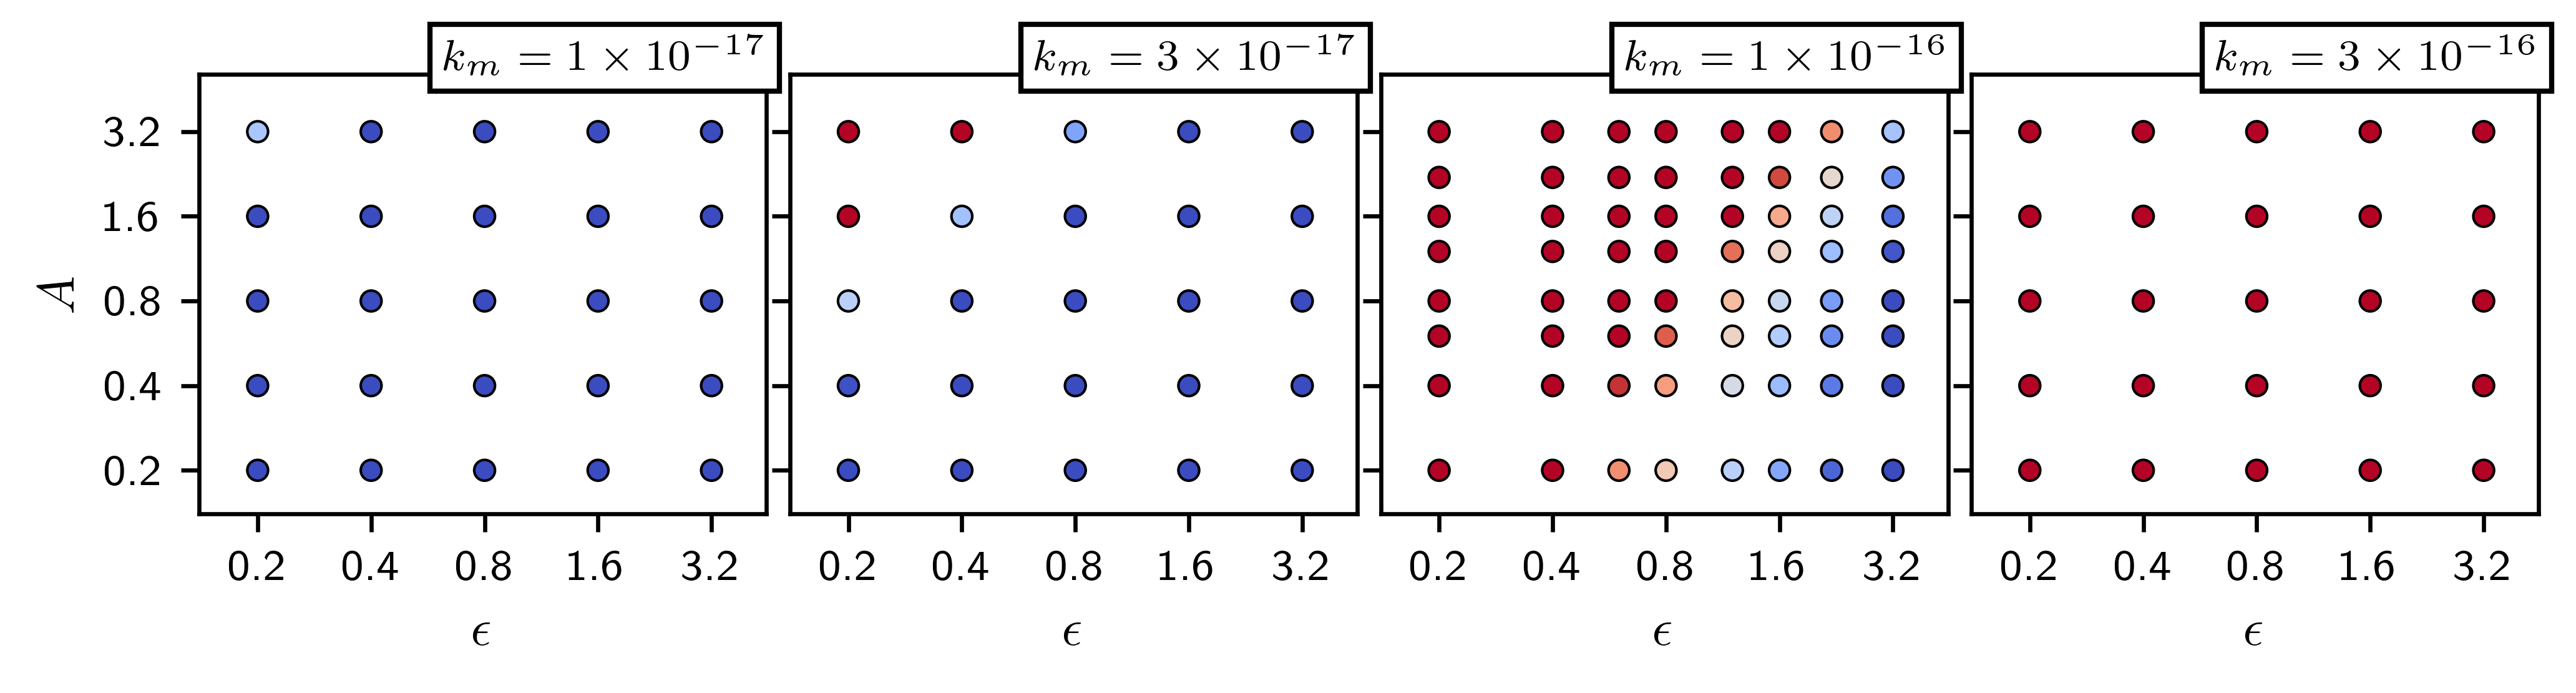

In [4]:
kbs = np.sort(np.unique(kb))
n = kbs.shape[0]


fig,axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(linewidth, linewidth/4))
cmap = matplotlib.colormaps['viridis']

axs[0].set_ylabel('$ A $')
for i,x in enumerate(kbs):
    ax = axs.flatten()[i]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(np.min(l) * 0.7, np.max(l) * 1.6)
    ax.set_xlim(np.min(eps) * 0.7, np.max(eps) * 1.4)
    
    ax.set_xticks([0.2, 0.4, 0.8, 1.6, 3.2], [0.2, 0.4, 0.8, 1.6, 3.2])
    ax.set_yticks([0.2, 0.4, 0.8, 1.6, 3.2], [0.2, 0.4, 0.8, 1.6, 3.2])
    ax.set_xticks([], minor=1)
    ax.set_yticks([], minor=1)
    ax.set_xlabel('$ \epsilon $')
    
    mask = (kb == x)
    eps_ = eps[mask]; l_ = l[mask]; val_ = val[mask]; npos_ = npos[mask]
    
#     xx = np.linspace(np.min(eps_), np.max(eps_), 300)
#     yy = np.linspace(np.min(l_), np.max(l_), 300)
#     xx, yy = np.meshgrid(xx, yy)
#     vv = scipy.interpolate.griddata((eps_, l_), val_, (xx, yy), method='cubic')
#     ax.pcolormesh(xx,yy,vv, vmin=-3, vmax=3, cmap='coolwarm')

#     for d in zip(eps_, l_, val_, npos_):
#         c = matplotlib.colormaps['coolwarm']( (d[2]+5)/10 )
#         ax.plot(d[0], d[1], c=c, marker='$ %d $' % d[3], markersize=4)
    ax.scatter(eps_, l_, c=val_, vmin=-5, vmax=5, cmap='coolwarm', **sp_kw)
    bbox = dict(facecolor='white', boxstyle='square,pad=0.3', edgecolor='black')
    ax.text(np.max(eps)*1.4, np.max(l)*1.55, r'$ k_m = \num{%.2g} $' % x, va='bottom', ha='right', fontsize='small', bbox=bbox)

#     Cs = [ a/b for a in l for b in eps ]
#     for C in np.logspace(np.log10(np.min(Cs)), np.log10(np.max(Cs)), 20): ax.plot(eps, C*eps, alpha=0.05, c='k')

fig.tight_layout(pad=0.1)
fig.savefig('../immagini/condensatori.png', **sf_kw|dict(pad_inches=.04))

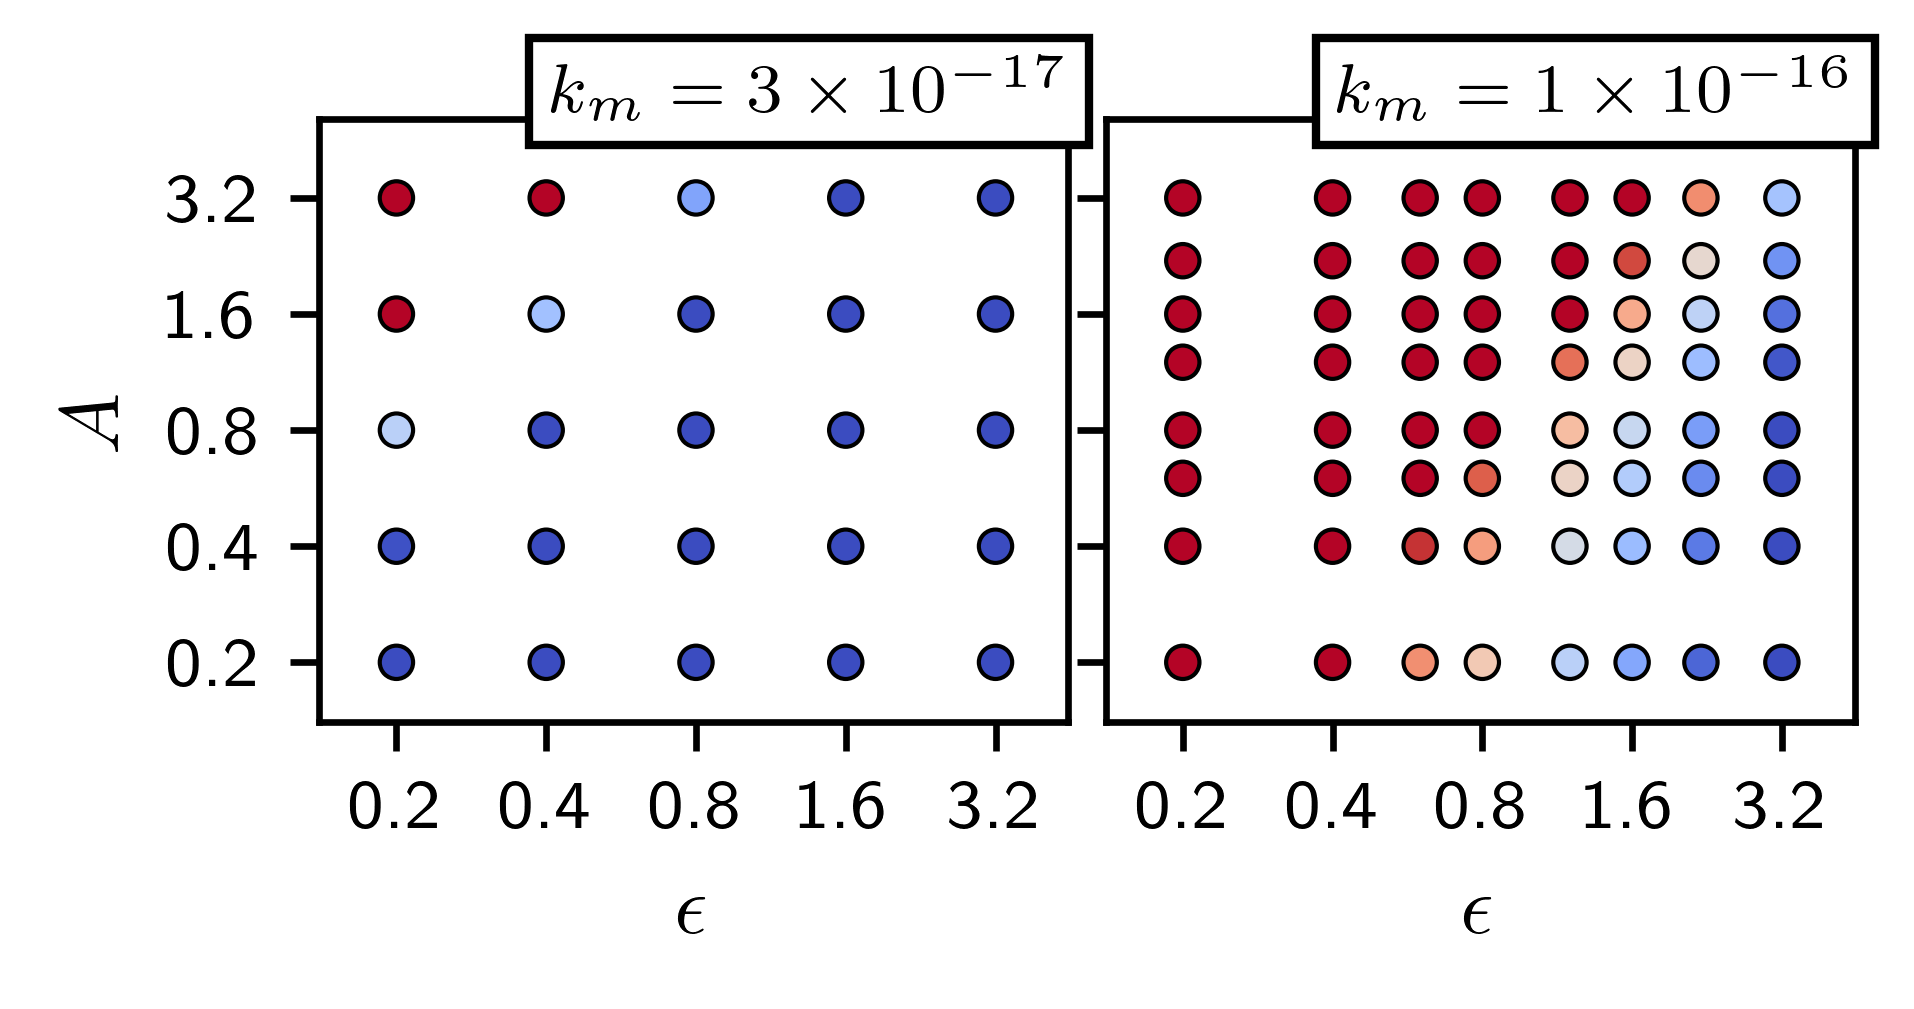

In [6]:
kbs = np.sort(np.unique(kb))
n = kbs.shape[0]


fig,axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(linewidth*.45, linewidth*.45/2))
cmap = matplotlib.colormaps['viridis']

axs[0].set_ylabel('$ A $')
for i,x in enumerate(kbs):
    if not i in [1,2]: continue
    ax = axs[i-1]
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(np.min(l) * 0.7, np.max(l) * 1.6)
    ax.set_xlim(np.min(eps) * 0.7, np.max(eps) * 1.4)
    
    ax.set_xticks([0.2, 0.4, 0.8, 1.6, 3.2], [0.2, 0.4, 0.8, 1.6, 3.2])
    ax.set_yticks([0.2, 0.4, 0.8, 1.6, 3.2], [0.2, 0.4, 0.8, 1.6, 3.2])
    ax.set_xticks([], minor=1)
    ax.set_yticks([], minor=1)
    ax.set_xlabel('$ \epsilon $')
    
    mask = (kb == x)
    eps_ = eps[mask]; l_ = l[mask]; val_ = val[mask]; npos_ = npos[mask]
    
#     xx = np.linspace(np.min(eps_), np.max(eps_), 300)
#     yy = np.linspace(np.min(l_), np.max(l_), 300)
#     xx, yy = np.meshgrid(xx, yy)
#     vv = scipy.interpolate.griddata((eps_, l_), val_, (xx, yy), method='cubic')
#     ax.pcolormesh(xx,yy,vv, vmin=-3, vmax=3, cmap='coolwarm')

#     for d in zip(eps_, l_, val_, npos_):
#         c = matplotlib.colormaps['coolwarm']( (d[2]+5)/10 )
#         ax.plot(d[0], d[1], c=c, marker='$ %d $' % d[3], markersize=4)
    ax.scatter(eps_, l_, c=val_, vmin=-5, vmax=5, cmap='coolwarm', **sp_kw)
    bbox = dict(facecolor='white', boxstyle='square,pad=0.3', edgecolor='black')
    ax.text(np.max(eps)*1.4, np.max(l)*1.55, r'$ k_m = \num{%.2g} $' % x, va='bottom', ha='right', fontsize='small', bbox=bbox)

#     Cs = [ a/b for a in l for b in eps ]
#     for C in np.logspace(np.log10(np.min(Cs)), np.log10(np.max(Cs)), 20): ax.plot(eps, C*eps, alpha=0.05, c='k')

fig.tight_layout(pad=0.1)
fig.savefig('../immagini/condensatori_piccola.png', **sf_kw|dict(pad_inches=0.05))

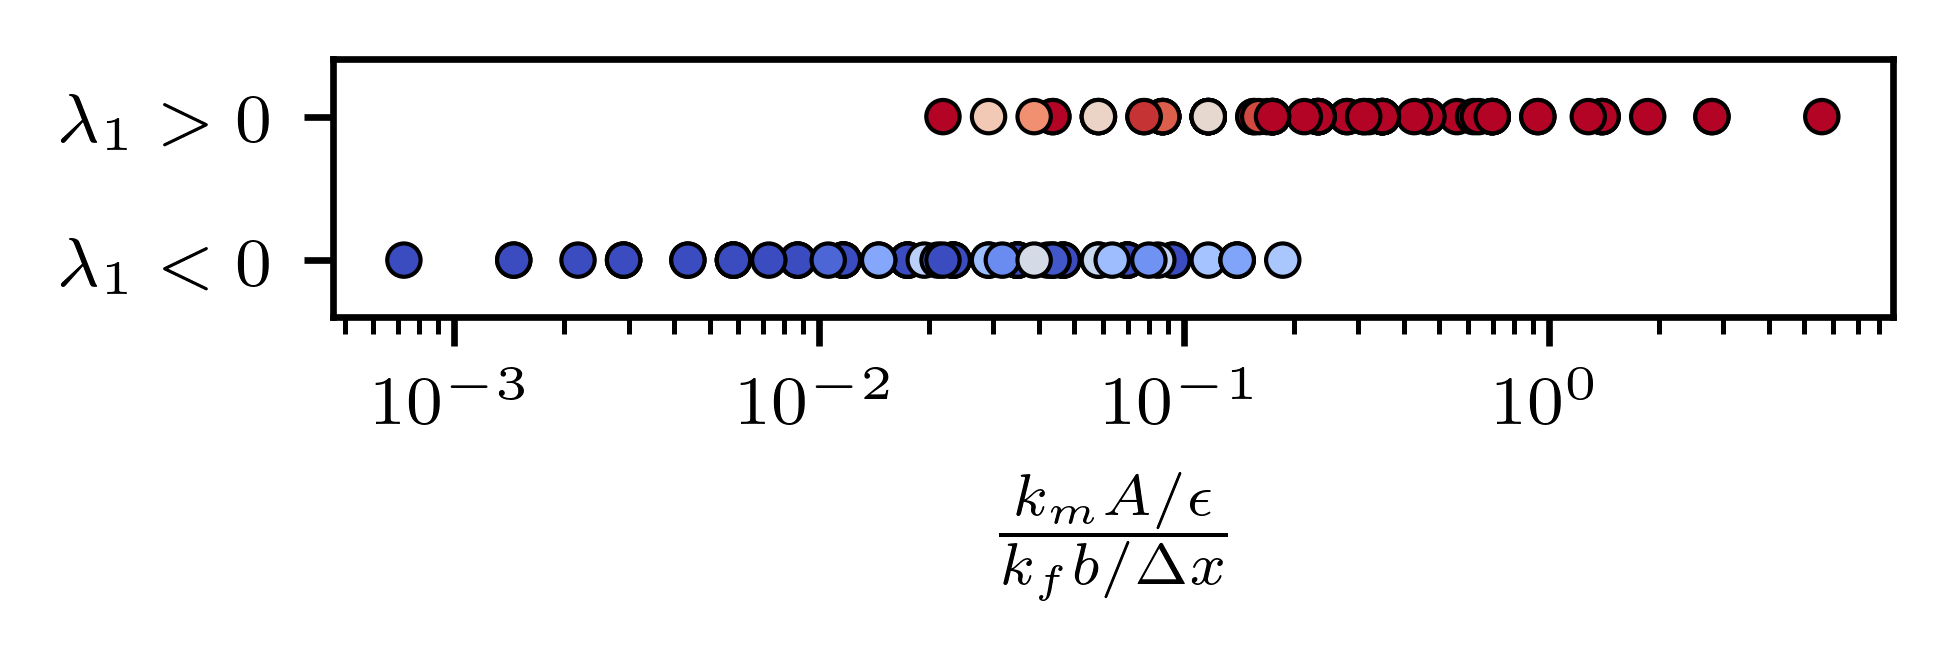

In [6]:
_, dati = condensatore(combinazioni[0])
dx = 10; dy = 5
quadre = 1 - eps/dx + eps*dati['permeabilita_fratture']*dati['apertura']/( dx*l*kb )
riduzione = 1/(1 + quadre*dx/dy)
riduzione_semplice =  dx*kb*l/( eps*dati['permeabilita_fratture']*dati['apertura'] )

fig,ax = plt.subplots(figsize=(linewidth/2, linewidth/2/6))
ax.scatter( riduzione_semplice, val > 0, c=val, vmin=-5, vmax=5, cmap='coolwarm', **sp_kw)
ax.set_xscale('log')
ax.set_ylim(-0.4, 1.4)
ax.set_yticks([0, 1], [r'$ \lambda_1 < 0 $', r'$ \lambda_1 > 0 $'])
ax.set_xlabel(r'$ \frac{ k_m A / \epsilon }{ k_f b / \Delta x } $')

fig.savefig('../immagini/condensatori_res.png', **sf_kw)

/home/arash/src/ddf/porepy/src/porepy/grids/mortar_grid.py:693: UserWarning: Is it really meaningful to ask for signs of a one sided mortar grid?
  warnings.warn(


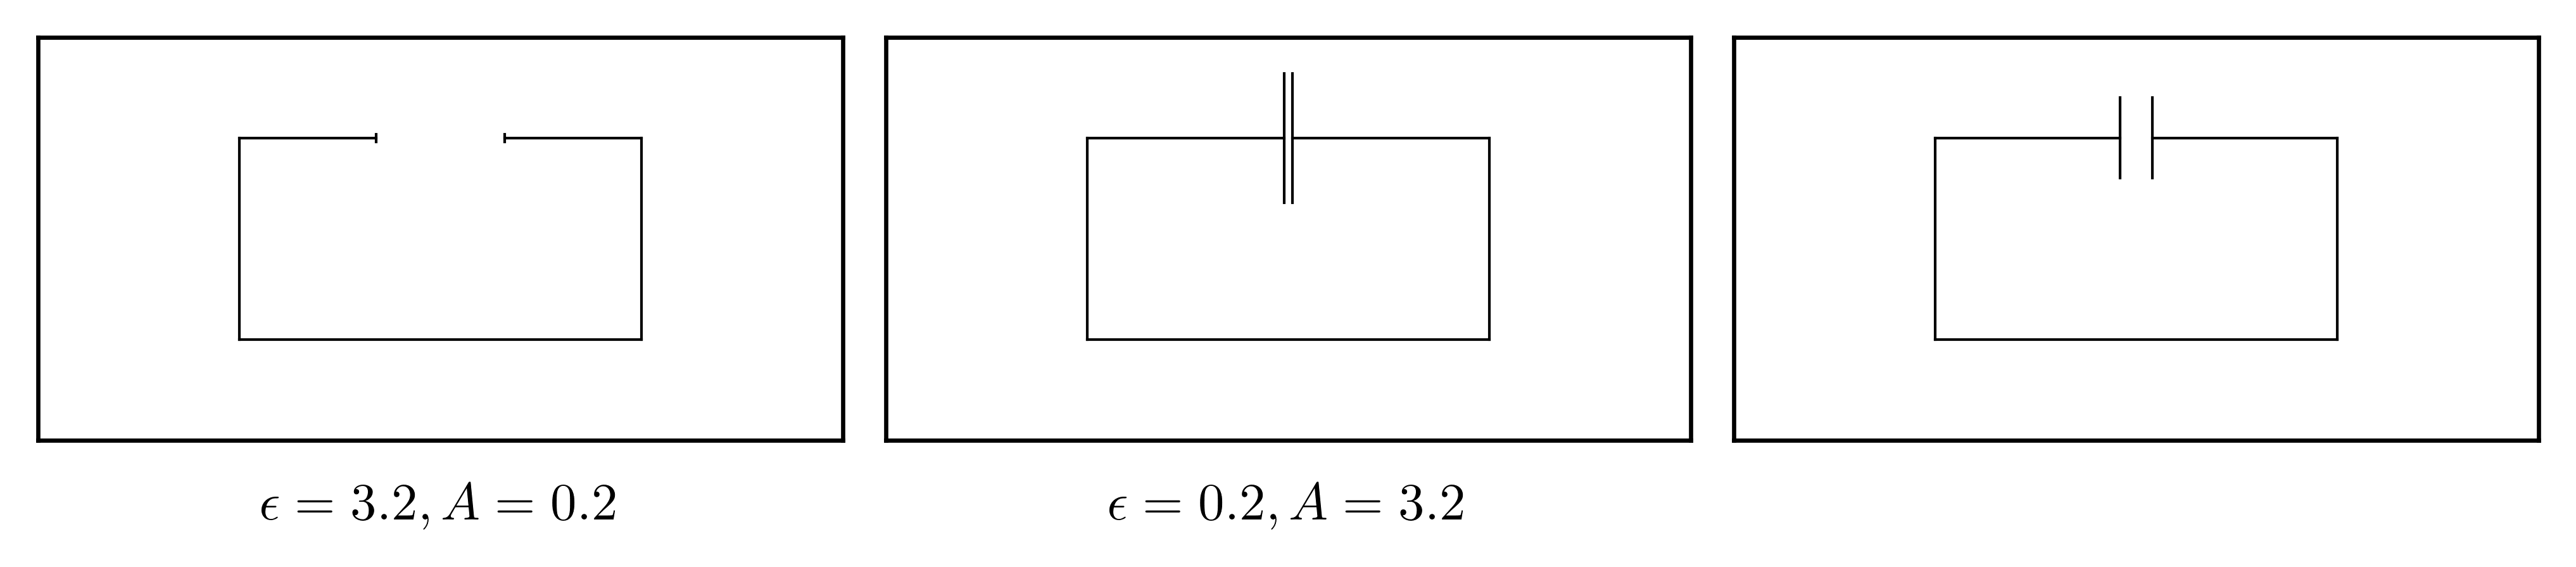

In [7]:
fig,axs = plt.subplots(1,3, figsize=(linewidth, linewidth/3/2*1.1))

mdg,dati = condensatore((3.2, 0.2, 1))
pb = hrl.HRL(mdg, dati, dict(parla=4))
pb.init()
plot_cells(pb, np.zeros(pb.mdg.subdomains()[0].num_cells), fratture_lw=0.5, fill=0, ax=axs[0])
axs[0].set_xlabel(r'$ \epsilon = 3.2, A = 0.2 $', labelpad=8)


mdg,dati = condensatore((0.2, 3.2, 1))
pb = hrl.HRL(mdg, dati, dict(parla=4))
pb.init()
plot_cells(pb, np.zeros(pb.mdg.subdomains()[0].num_cells), fratture_lw=0.5, fill=0, ax=axs[1])
axs[1].set_xlabel(r'$ \epsilon = 0.2, A = 3.2 $', labelpad=8)

    
mdg,dati = condensatore((0.8, 2.0, 1))
pb = hrl.HRL(mdg, dati, dict(parla=4))
pb.init()
plot_cells(pb, np.zeros(pb.mdg.subdomains()[0].num_cells), fratture_lw=0.5, fill=0, ax=axs[2])
# axs[2].set_xlabel(r'$ \epsilon = 3.2, A = 0.2 $')


fig.tight_layout(pad=0.1)
fig.savefig('../immagini/condensatori_tmp.svg', **sf_kw)